### Imports

In [3]:
import numpy as np
#import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# from google.colab import files

In [5]:
# !cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/carbon_levels.py /content
# !cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/past.py /content
# !cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/params.py /content
# !cp /content/gdrive/MyDrive/ColabHannah/new_biota/pyfiles/future.py /content
import os

wd = os.getcwd()
# print(wd)
os.chdir(wd +'/pyfiles/')
wd = os.getcwd()

print(wd)

C:\Users\rjmay\Code\GES\src\pyfiles


In [6]:
import carbon_levels
import past
import params
from future import scenario

### Parameters  and conversion factors


In [7]:
ka, kd, delta_d, kH, AM, OM, M_upper, delta_a, K_1, K_2, Alk = params.ocean_params
mumix, mudeep, lambdaHat, gamma = params.temp_params
tao, beta,Cpf_moles, propCH4, propPassive, pf_init_T = params.permafrost_params
fds, fld, fls, flv, fnd, fns, fnv, frd, frs, fvd, fvs, beta_biota, q10, biota_init_T, npp_0 = params.biota_params

In [8]:
ppmtoMol = 1.77e+14 #mult by this for CO2 PPM -> Moles
molCO2toGT =  4.4e-14 #mult by this for moles CO2 -> GTC
ppmtoGT = 7.788 #mult by this for ppm to GTC
molCtoGT = 12/1e15

### Data



Getting the data in ppm for $CO_2$

In [9]:
file_loc = r"../../Data/WG1AR5_AIISM_Datafiles.xlsx"

# ppm_Data  = pd.read_excel(file_loc, 6, header = 7, index_col=0, usecols="A:D", skiprows=[8],skipfooter=40) #ppm
ppm_data_source  = pd.read_excel(file_loc, 6, header = 7, usecols="A:D", skiprows=[8],skipfooter=40) #ppm  NOte I didn't do an index col so I could get an array of years. 


ppm_data_source.columns = ['Year', 'CO2', 'CH4', 'N2O']

In [10]:
#linear interpolation

ppm_data = pd.DataFrame(columns=['Year', 'CO2', 'CH4', 'N2O'])

for k in ppm_data.columns:
    ppm_data[k] =  np.interp(np.arange(1750,2011), ppm_data_source.Year, ppm_data_source[k])

ppm_data = ppm_data.astype({'Year':'int'})




Getting the data in terms of ERF

In [11]:
# ERF_data  = pd.read_excel(file_loc, 8, header = 7, usecols="A:M", skipfooter=5) #ppm  NOte I didn't do an index col so I could get an array of years. 


 Carbon data

In [12]:

#global K_H K_1 K_2 delta_d delta_a AM Alk k_a k_d E_course
fname = r'../../Data/Global_Carbon_Budget_2021v1.0.xlsx'

carbon_df = pd.read_excel(fname, sheet_name = "Historical Budget", header = 16,
                                 names = ['Year', 'Fossil', 'LUC', 'Atm_Growth', 'Ocean_Sink', 'Land_Sink', 'Cement_Carb_Sink', 'Imbalance']);

#Dr Eikenberry's linear interp
#Do a linear interpolation from 0.2 to value at 1850 for LUC:
carbon_df.LUC.iloc[0:99] = np.interp(carbon_df.Year[0:99], [1751, 1849], [0.2, carbon_df.LUC[99]])

C:\Users\rjmay\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Past Modeling

In [13]:
init_ppm = params.ppmCO2_1750 

initC = carbon_levels.get_C_init(init_ppm)
# new_QA = 1000 * ppmtoMol
# start_ocean = np.array([new_QA, 725 * ppmtoMol, 36262 * ppmtoMol])

# print(initC * 12/ 1e15)

temp = np.array([0,0])

inits = np.concatenate((temp,initC), axis=None)

t_span=[1750,2010]
# ERF_data.head()


sol_2010, temp_track = past.solve_past(t_span, inits, ppm_data, carbon_df, True)



C:\Users\rjmay\Code\GES\src\pyfiles\past.py:95: RuntimeWarning: divide by zero encountered in log
  result = (npp_0 / molCtoGT) * (1 + beta_biota * ( np.log ( carbon /  params.ppmCO2_1750 )))


In [14]:
#state 2010
index_max = len(sol_2010.t) - 1
state_2010 = sol_2010.y[:,index_max] #QA not right here!!!!!

ppm_2010 = ppm_data.loc[ppm_data["Year"] == 2010].values[0][1]

molesQA = ppm_2010 / 1e6 * AM
state_2010[2] = molesQA

state_2010 * 12 / 1e15
# state_2010

array([9.72918126e-15, 2.63879141e-15, 8.24913789e+02, 7.40347498e+02,
       3.63102800e+04, 5.36945253e+02, 5.97344166e+01, 1.76711319e+03])

#### Figures

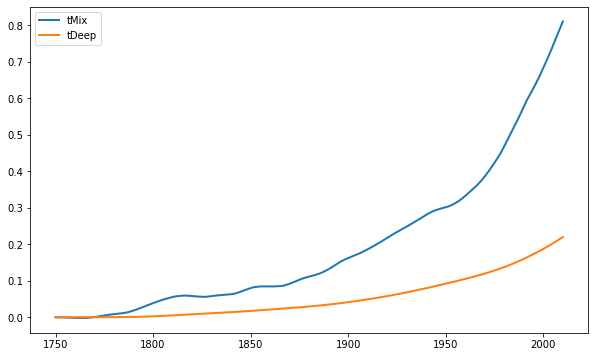

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

ax1.plot(sol_2010.t, sol_2010.y[0,:], linewidth=2, label='tMix')
ax1.plot(sol_2010.t, sol_2010.y[1,:], linewidth=2, label='tDeep')
ax1.legend()


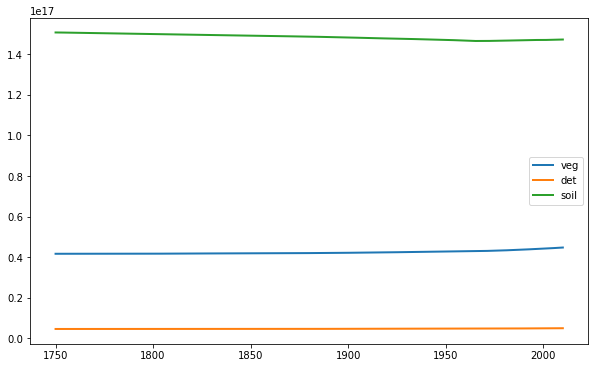

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

ax1.plot(sol_2010.t, sol_2010.y[5,:], linewidth=2, label='veg')
ax1.plot(sol_2010.t, sol_2010.y[6,:], linewidth=2, label='det')
ax1.plot(sol_2010.t, sol_2010.y[7,:], linewidth=2, label='soil')

ax1.legend()

## Future data emissions
Starting to use emissions for future data analysis

#### Data and Methane Scenarios
Future RCP scenarios 

2.6, 4.5, 6, 8.5

In [18]:
choice = "26"

file_loc = r"../../Data/emissions/RCP"+choice+"_emissions.csv"

RCP_emit_df = pd.read_csv(file_loc, header = 3, usecols=[0,1,2,3,4,5], names = ["Year", "Fossil", "LUC", "CH4", "N2O", "SOx"] )

### Future model

In [19]:
# https://www.eea.europa.eu/data-and-maps/daviz/atmospheric-concentration-of-carbon-dioxide-5'
#2010 levels
ppbM = 1798
ppbN = 323.7 

In [20]:
tspan = [2010, 2300]

# IC_PF = np.array([7.93713150e+16, 6.20641903e+15, 1.46108124e+14 ])#  cpf, Lc, Lm Init For PF
IC_PF = np.array([Cpf_moles, 0, 0 ])#  cpf, Lc, Lm Init For PF

state = np.concatenate((state_2010, [ppbM, ppbN], IC_PF), axis = None)


In [21]:

#order of parameters
# tspan, state, RCP, custom_ch4(False), reduction of methane factor = .9, baseline=  140
obj = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True))
obj1 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, .95)
obj2 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, .9)


#baselines = 26 = 142
#45 = 268.46
#6 = 252.1

In [22]:
sol = obj.get_scenario()
sol1 = obj1.get_scenario()
sol2 = obj2.get_scenario()

label = obj.getFinalTemp()
label1 = np.around(label, decimals=2)

print(obj.getFinalTemp(), obj1.getFinalTemp(), obj2.getFinalTemp())
r26_t2100 = obj.getTemp2100()
print(r26_t2100)



1.3759083142462645 1.370137448886011 1.3691279860299144
1.7332287653233382


In [23]:
solpf = obj.get_scenarioPF()
sol1pf = obj1.get_scenarioPF()
sol2pf = obj2.get_scenarioPF()

label = obj.getFinalTemp()
label2 = np.around(label, decimals=2)
print(obj.getFinalTemp(), obj1.getFinalTemp(), obj2.getFinalTemp())
print(label2)

r26_t2100pf = obj.getTemp2100()
print(r26_t2100pf)



1.616242653417547 1.6037622902761068 1.5931223575852955
1.62
1.869948537481697


In [24]:
netCarbon = np.sum(obj.getEmitPF()[2010:2300,:], axis = 1)
maxC =np.around(np.max(netCarbon) * molCtoGT, decimals = 1)

netCarbon1 = np.sum(obj1.getEmitPF()[2010:2300,:], axis = 1)
maxC1 = np.around(np.max(netCarbon1) * molCtoGT, decimals = 1)

netCarbon2 = np.sum(obj2.getEmitPF()[2010:2300,:], axis =1)
maxC2 = np.around(np.max(netCarbon2) * molCtoGT, decimals = 1)

print(maxC, maxC1, maxC2)


98.3 95.3 94.3


In [25]:
choice = "45"
file_loc = r"../../Data/emissions/RCP"+choice+"_emissions.csv"
RCP_emit_df = pd.read_csv(file_loc, header = 3, usecols=[0,1,2,3,4,5], names = ["Year", "Fossil", "LUC", "CH4", "N2O", "SOx"] )


In [26]:
# tspan, state, RCP, custom_ch4(False), reduction of methane factor = .9, baseline=  140
obj45 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True))
obj45v1 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, .99, 266)
obj45v10 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, .9, 266)

sol45 = obj45.get_scenario()
sol45v1 = obj45v1.get_scenario()
sol45v10 = obj45v10.get_scenario()

label45 = np.around(obj45.getFinalTemp(), decimals=2)
r45_t2100 = obj45.getTemp2100()
print(r45_t2100)

# print(label45)

sol45_PF = obj45.get_scenarioPF()
sol45v1_PF = obj45v1.get_scenarioPF()
sol45v10_PF = obj45v10.get_scenarioPF()

label45_PF = np.around(obj45.getFinalTemp(), decimals=2)
r45_t2100pf = obj45.getTemp2100()
print(r45_t2100pf)
# print(label45_PF)

2.596196548706831
2.7667763053114287


In [29]:
netC45 = np.sum(obj45.getEmitPF()[2010:2300,:], axis = 1)
maxC45 = np.around(np.max(netC45) * molCtoGT , decimals = 1)

netC45_v1 = np.sum(obj45v1.getEmitPF()[2010:2300,:], axis = 1)
maxC45_v1 = np.around(np.max(netC45_v1) * molCtoGT , decimals =1)

netC45_v10 = np.sum(obj45v10.getEmitPF()[2010:2300,:], axis =1)
maxC45_v10 = np.around(np.max(netC45_v10) * molCtoGT , decimals =1)

print(maxC45, maxC45_v1, maxC45_v10)


277.7 276.6 276.3


In [30]:
choice = "6"
file_loc = r"../../Data/emissions/RCP"+choice+"_emissions.csv"
RCP_emit_df = pd.read_csv(file_loc, header = 3, usecols=[0,1,2,3,4,5], names = ["Year", "Fossil", "LUC", "CH4", "N2O", "SOx"] )

In [31]:
# tspan, state, RCP, custom_ch4(False), reduction of methane factor = .9, baseline=  140
obj6 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True))
obj6v1 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, .99, 252)
obj6v10 = scenario(tspan, state, np.copy(temp_track), RCP_emit_df.copy(deep=True), True, .9, 252)


sol6 = obj6.get_scenario()
sol6v1 = obj6v1.get_scenario()
sol6v10 = obj6v10.get_scenario()

label6 = np.around(obj6.getFinalTemp(), decimals=2)
r6_t2100 = obj6.getTemp2100()
print(r6_t2100)
# print(label6)

sol6_PF = obj6.get_scenarioPF()
sol6v1_PF = obj6v1.get_scenarioPF()
sol6v10_PF = obj6v10.get_scenarioPF()

label6_PF = np.around(obj6.getFinalTemp(), decimals=2)
r6_t2100pf = obj6.getTemp2100()
print(r6_t2100pf)
# print(label6_PF)

3.1545417296073133
3.310640486687398


In [32]:
#!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

In [33]:
#fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])

In [34]:
netC6 = np.sum(obj6.getEmitPF()[2010:2300,:], axis = 1)
maxC6 = np.around(np.max(netC6) * molCtoGT, decimals = 1)

netC6_v1 = np.sum(obj6v1.getEmitPF()[2010:2300,:], axis = 1)
maxC6_v1 = np.around(np.max(netC6_v1) * molCtoGT , decimals = 1)

netC6_v10 = np.sum(obj6v10.getEmitPF()[2010:2300,:], axis =1)
maxC6_v10 = np.around(np.max(netC6_v10) * molCtoGT, decimals = 1)

print(maxC6, maxC6_v1, maxC6_v10)

392.5 391.1 391.5


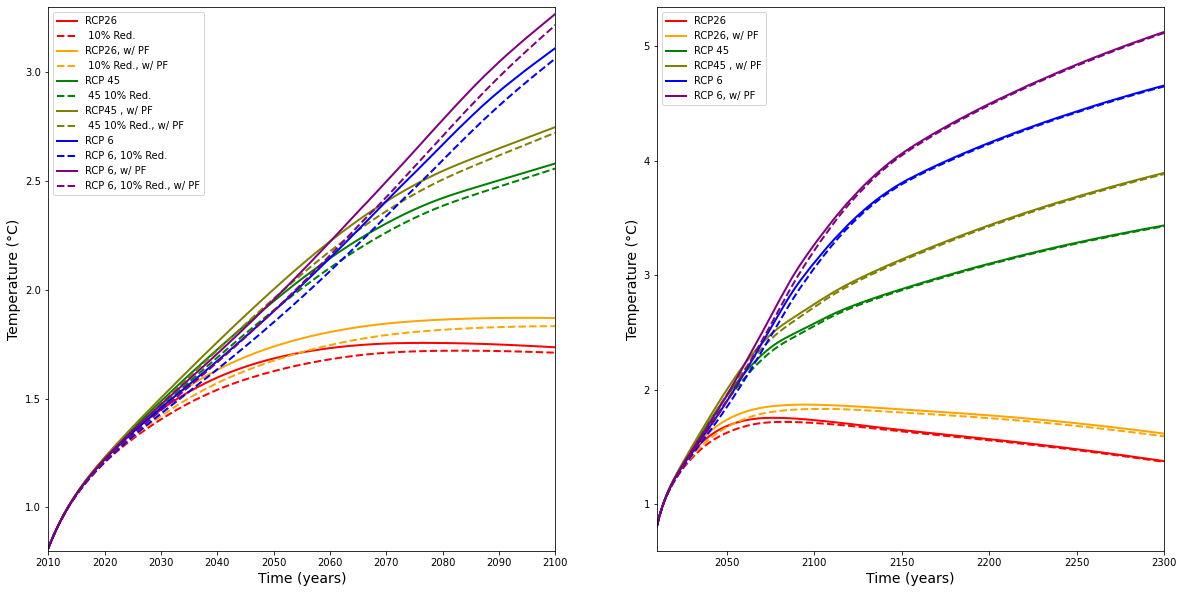

In [35]:
fig, ax1 = plt.subplots(1, 2, figsize=(20,10))
fs = 14


#plt.rcParams["font.family"] = "Times New Roman"

coord = 0
ax1[coord].plot(sol.t, sol.y[0,:],linewidth=2, label = "RCP26", color ="red")
# ax1[coord].plot(sol1.t, sol1.y[0,:], linewidth=2, label = " 5% Red.", linestyle = "dashed")
ax1[coord].plot(sol2.t, sol2.y[0,:], linewidth=2, label = " 10% Red.", linestyle = "dashed", color ="red")
ax1[coord].plot(solpf.t, solpf.y[0,:],linewidth=2, label = "RCP26, w/ PF", color = "orange")
# ax1[coord].plot(sol1pf.t, sol1pf.y[0,:],linewidth=2,  label = " 5% Red., w/ PF", linestyle = "dashed")
ax1[coord].plot(sol2pf.t, sol2pf.y[0,:], linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed", color="orange")


ax1[coord].plot(sol45.t, sol45.y[0,:],linewidth=2, label = "RCP 45", color = "green")
# ax1[coord].plot(sol45v1.t, sol45v1.y[0,:], linewidth=2, label = " 45 1% Red.", linestyle = "dashed")
ax1[coord].plot(sol45v10.t, sol45v10.y[0,:], linewidth=2, label = " 45 10% Red.", linestyle = "dashed", color= "green")
ax1[coord].plot(sol45_PF.t, sol45_PF.y[0,:],linewidth=2, label = "RCP45 , w/ PF", color = "olive")
# ax1[coord].plot(sol45v1_PF.t, sol45v1_PF.y[0,:],linewidth=2,  label = " 45 1% Red., w/ PF", linestyle = "dashed")
ax1[coord].plot(sol45v10_PF.t, sol45v10_PF.y[0,:], linewidth=2, label = " 45 10% Red., w/ PF", linestyle = "dashed", color ="olive")

ax1[coord].plot(sol6.t, sol6.y[0,:],linewidth=2, label = "RCP 6", color = "blue")
# ax1[coord].plot(sol6v1.t, sol6v1.y[0,:], linewidth=2, label = "6, 1% Red.", linestyle = "dashed")
ax1[coord].plot(sol6v10.t, sol6v10.y[0,:], linewidth=2, label = "RCP 6, 10% Red.", linestyle = "dashed", color = "blue")
ax1[coord].plot(sol6_PF.t, sol6_PF.y[0,:],linewidth=2, label = "RCP 6, w/ PF", color = "purple")
# ax1[coord].plot(sol6v1_PF.t, sol6v1_PF.y[0,:],linewidth=2,  label = "6, 1% Red., w/ PF", linestyle = "dashed")
ax1[coord].plot(sol6v10_PF.t, sol6v10_PF.y[0,:], linewidth=2, label = "RCP 6, 10% Red., w/ PF", linestyle = "dashed", color = "purple")

ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("Temperature (°C)", fontsize = fs)
# ax1[coord].set_title("RCP 26, 45, 6: Temperature Perturbation since 1750" ,fontsize = fs +2)
ax1[coord].legend()
ax1[coord].set_xlim(2010,2100)
ax1[coord].set_ylim(0.8,3.3)




coord = 1
ax1[coord].plot(sol.t, sol.y[0,:],linewidth=2, label = "RCP26", color="red")
# ax1[coord].plot(sol1.t, sol1.y[0,:], linewidth=2, linestyle = "dashed")
ax1[coord].plot(sol2.t, sol2.y[0,:], linewidth=2, linestyle = "dashed", color ="red")
ax1[coord].plot(solpf.t, solpf.y[0,:],linewidth=2, label = "RCP26, w/ PF", color = "orange")
# ax1[coord].plot(sol1pf.t, sol1pf.y[0,:],linewidth=2,   linestyle = "dashed")
ax1[coord].plot(sol2pf.t, sol2pf.y[0,:], linewidth=2,  linestyle = "dashed", color = "orange")

ax1[coord].plot(sol45.t, sol45.y[0,:],linewidth=2, label = "RCP 45", color = "green")
# ax1[coord].plot(sol45v1.t, sol45v1.y[0,:], linewidth=2, linestyle = "dashed")
ax1[coord].plot(sol45v10.t, sol45v10.y[0,:], linewidth=2,  linestyle = "dashed", color = "green")
ax1[coord].plot(sol45_PF.t, sol45_PF.y[0,:],linewidth=2, label = "RCP45 , w/ PF", color ="olive")
# ax1[coord].plot(sol45v1_PF.t, sol45v1_PF.y[0,:],linewidth=2, linestyle = "dashed")
ax1[coord].plot(sol45v10_PF.t, sol45v10_PF.y[0,:], linewidth=2,  linestyle = "dashed", color = "olive")

ax1[coord].plot(sol6.t, sol6.y[0,:],linewidth=2, label = "RCP 6", color = "blue")
# ax1[coord].plot(sol6v1.t, sol6v1.y[0,:], linewidth=2,  linestyle = "dashed")
ax1[coord].plot(sol6v10.t, sol6v10.y[0,:], linewidth=2, linestyle = "dashed", color = "blue")
ax1[coord].plot(sol6_PF.t, sol6_PF.y[0,:],linewidth=2, label = "RCP 6, w/ PF", color = "purple")
# ax1[coord].plot(sol6v1_PF.t, sol6v1_PF.y[0,:],linewidth=2,  linestyle = "dashed")
ax1[coord].plot(sol6v10_PF.t, sol6v10_PF.y[0,:], linewidth=2, linestyle = "dashed", color = "purple")

ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("Temperature (°C)", fontsize = fs)
# ax1[coord].set_title("RCP 26, 45, 6" , fontsize = fs +2)
ax1[coord].set_xlim(2010,2300)
ax1[coord].legend()






# fname = "AllTemps.png"
# plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# files.download(fname)

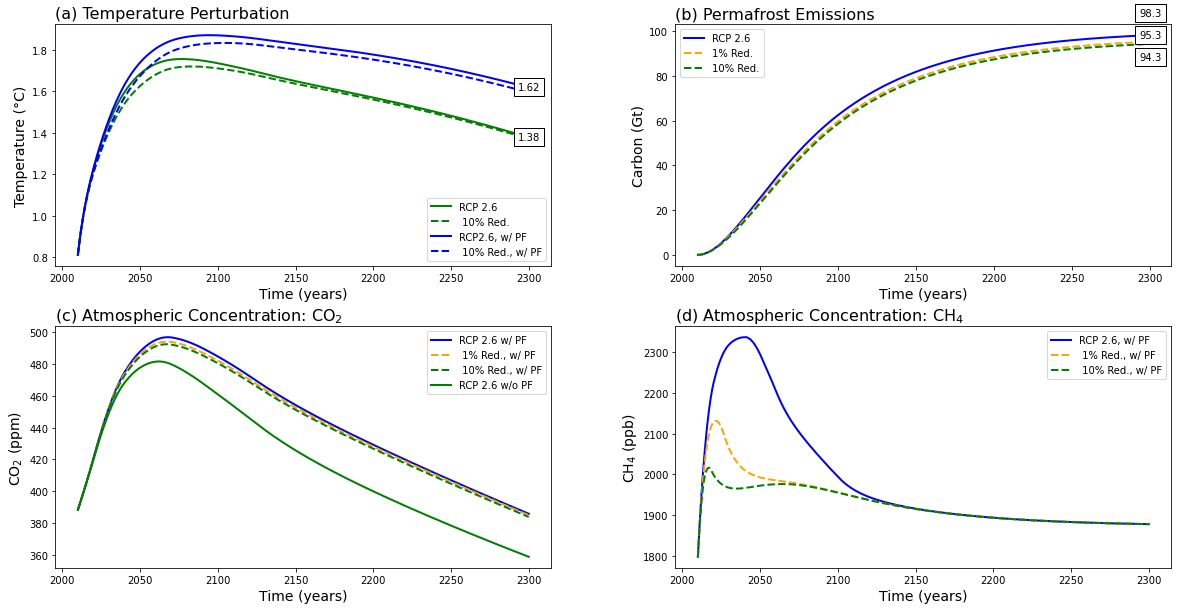

In [38]:
# To clear cache file of matplotlib
#!rm ~/.cache/matplotlib -rf
fig, ax1 = plt.subplots(2, 2, figsize=(20,10))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
#plt.rcParams["font.family"] = "Times New Roman"

fs = 14


scen = "RCP 2.6"
t= np.arange(2010,2300,1)

coord = 0,0
ax1[coord].plot(sol.t, sol.y[0,:],linewidth=2, label = "RCP 2.6", color = "g")
# ax1[coord].plot(sol1.t, sol1.y[0,:], linewidth=2, label = " 5% Red.", linestyle = "dashed")
ax1[coord].plot(sol2.t, sol2.y[0,:], linewidth=2, label = " 10% Red.", linestyle = "dashed", color = "g")
ax1[coord].plot(solpf.t, solpf.y[0,:],linewidth=2, label = "RCP2.6, w/ PF", color = "b")
# ax1[coord].plot(sol1pf.t, sol1pf.y[0,:],linewidth=2,  label = " 5% Red., w/ PF", linestyle = "dashed")
ax1[coord].plot(sol2pf.t, sol2pf.y[0,:], linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed", color = "b")

ax1[coord].text(2300, label1, label1, fontsize=10,
        bbox={'facecolor':'white', 'edgecolor':'black'},
        ha='center', va='center')
ax1[coord].text(2300, label2, label2 , fontsize=10, 
      bbox={'facecolor':'white','edgecolor':'black'},
      ha='center', va='center')

ax1[coord].legend()
ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("Temperature (°C)", fontsize = fs)
ax1[coord].set_title("(a) Temperature Perturbation", loc='left', fontsize = fs +2)
#ax1[coord].set_title("(a) Temperature Perturbation", loc='left', fontsize = fs +2)



coord= 0,1
ax1[coord].plot(t, netCarbon * molCtoGT ,linewidth=2, label = scen, color ="b")
ax1[coord].plot(t, netCarbon1 * molCtoGT ,linewidth=2, label = "1% Red.", linestyle = "dashed", color="orange")
ax1[coord].plot(t, netCarbon2 * molCtoGT ,linewidth=2, label = "10% Red.", linestyle = "dashed", color="green")

ax1[coord].text(2300, maxC + 10, maxC, fontsize=10,
                bbox={'facecolor':'white', 'edgecolor':'black'},
         ha='center', va='center')
ax1[coord].text(2300, maxC, maxC1 , fontsize=10,
                bbox={'facecolor':'white','edgecolor':'black'},
         ha='center', va='center')
ax1[coord].text(2300, maxC - 10, maxC2 , fontsize=10,
                bbox={'facecolor':'white','edgecolor':'black'},
         ha='center', va='center')
                

ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("Carbon (Gt)", fontsize = fs)
ax1[coord].set_title("(b) Permafrost Emissions" ,loc='left', fontsize = fs +2)



ax1[coord].legend()


coord = 1,0
# ax1[coord].plot(sol.t, (sol.y[2,:] / ppmtoMol),linewidth=2, label = scen)
# ax1[coord].plot(sol1.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 1% Red.", linestyle = "dashed")
# ax1[coord].plot(sol2.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 10% Red.", linestyle = "dashed")
ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("CO$_2$ (ppm)", fontsize = fs)
ax1[coord].plot(solpf.t, solpf.y[2,:] / ppmtoMol, linewidth=2, label = scen + " w/ PF", color="blue")
ax1[coord].plot(sol1pf.t, sol1pf.y[2,:] / ppmtoMol,linewidth=2,  label = " 1% Red., w/ PF", linestyle = "dashed", color="orange")
ax1[coord].plot(sol2pf.t, sol2pf.y[2,:]/ ppmtoMol, linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed",color="green")
ax1[coord].plot(sol.t, sol.y[2,:] / ppmtoMol, linewidth=2, label = scen + " w/o PF", color="green")

ax1[coord].set_title("(c) Atmospheric Concentration: CO$_2$" , loc='left', fontsize = fs +2)
ax1[coord].legend()

coord = 1,1
# ax1[coord].plot(sol.t,sol.y[8,:],linewidth=2, label = scen)
# ax1[coord].plot(sol1.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 1% Red.", linestyle = "dashed")
# ax1[coord].plot(sol2.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 10% Red.", linestyle = "dashed")
ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("CH$_4$ (ppb)", fontsize = fs)
ax1[coord].plot(solpf.t, solpf.y[8,:]*1e9/AM , linewidth=2, label = "RCP 2.6, w/ PF", color ="blue")
ax1[coord].plot(sol1pf.t, sol1pf.y[8,:]*1e9/AM ,linewidth=2,  label = " 1% Red., w/ PF", linestyle = "dashed", color="orange")
ax1[coord].plot(sol2pf.t, sol2pf.y[8,:]*1e9/AM, linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed", color="green")
ax1[coord].set_title("(d) Atmospheric Concentration: CH$_4$" , loc='left', fontsize = fs +2)

ax1[coord].legend()




# fname = "RCP26fixed.png"
# plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# files.download(fname)


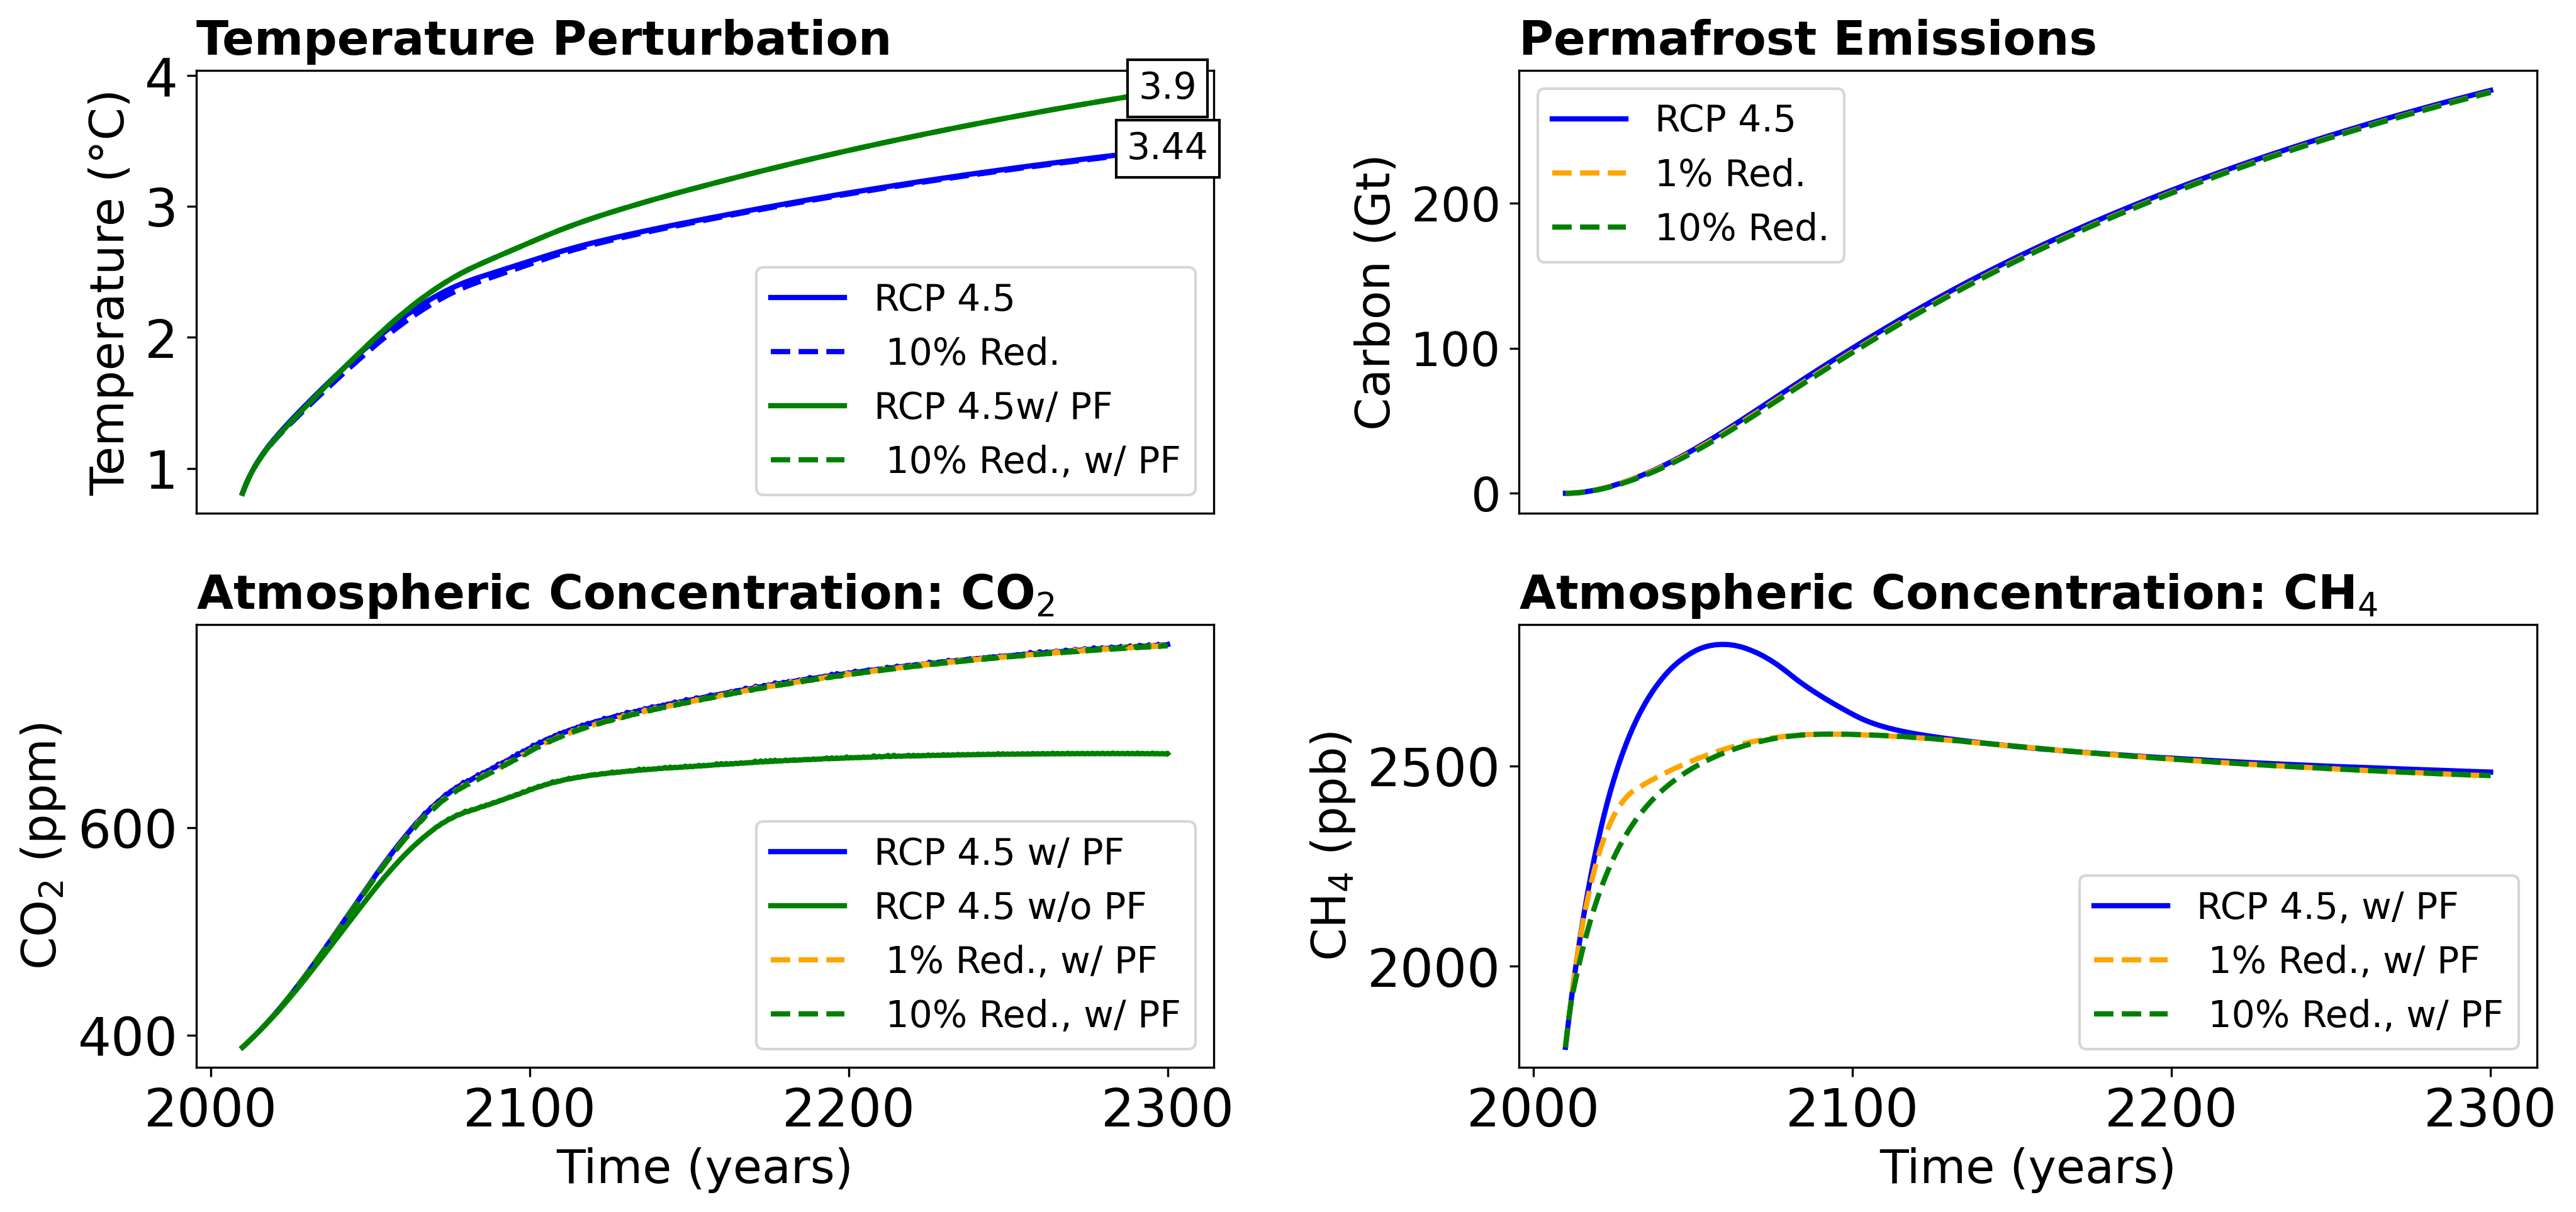

In [39]:

fig, ax1 = plt.subplots(2, 2, figsize=(16,7), dpi =300)
plt.subplots_adjust(wspace=0.3, hspace=0.25)

fs = 18
scen = "RCP 4.5"

t= np.arange(2010,2300,1)

coord = 0,0
ax1[coord].plot(sol45.t, sol45.y[0,:],linewidth=2, label = scen, color ="blue")
# ax1[coord].plot(sol1.t, sol45v1.y[0,:], linewidth=2, label = " 5% Red.", linestyle = "dashed")
ax1[coord].plot(sol45v10.t, sol45v10.y[0,:], linewidth=2, label = " 10% Red.", linestyle = "dashed", color ="blue")
ax1[coord].plot(sol45v10_PF.t, sol45v10_PF.y[0,:],linewidth=2, label = scen + "w/ PF", color ="green")
# ax1[coord].plot(sol1pf.t, sol45v1_PF.y[0,:],linewidth=2,  label = " 5% Red., w/ PF", linestyle = "dashed")
ax1[coord].plot(sol45v10_PF.t, sol45v10_PF.y[0,:], linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed", color = "green")

ax1[coord].text(2300, label45, label45, fontsize=fs-4,
        bbox={'facecolor':'white', 'edgecolor':'black'},
        ha='center', va='center')
ax1[coord].text(2300, label45_PF, label45_PF , fontsize=fs-4, 
      bbox={'facecolor':'white','edgecolor':'black'},
      ha='center', va='center')

ax1[coord].set_xticks([])
ax1[coord].tick_params(axis='both', labelsize=20)
ax1[coord].legend(fontsize = fs-4)
# ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("Temperature (°C)", fontsize = fs)
ax1[coord].set_title("Temperature Perturbation", loc='left', fontsize = fs, fontweight = "bold")

coord= 0,1
ax1[coord].plot(t, netC45 * molCtoGT ,linewidth=2, label = scen, color = "blue")
ax1[coord].plot(t, netC45_v1 * molCtoGT ,linewidth=2, label = "1% Red.", linestyle = "dashed", color = "orange")
ax1[coord].plot(t, netC45_v10 * molCtoGT ,linewidth=2, label = "10% Red.", linestyle = "dashed", color ="green")
# ax1[coord].text(2300, maxC45 + 20, maxC45, fontsize=10,
#                 bbox={'facecolor':'white', 'edgecolor':'black'},
#          ha='center', va='center')
# ax1[coord].text(2300, maxC45, maxC45_v1, fontsize=10,
#                 bbox={'facecolor':'white','edgecolor':'black'},
#          ha='center', va='center')
# ax1[coord].text(2300, maxC45 - 20, maxC45_v10, fontsize=10,
#                 bbox={'facecolor':'white','edgecolor':'black'},
#          ha='center', va='center')
                

# ax1[coord].set_xlabel("Time (years) ", fontsize = fs)
ax1[coord].set_xticks([])
ax1[coord].tick_params(axis='both', labelsize=fs)
ax1[coord].set_ylabel("Carbon (Gt)", fontsize = fs)
ax1[coord].set_title("Permafrost Emissions", loc='left', fontsize = fs , fontweight= "bold")
ax1[coord].legend(fontsize = fs-4)





coord = 1,0
# ax1[coord].plot(sol.t, (sol.y[2,:] / ppmtoMol),linewidth=2, label = scen)
# ax1[coord].plot(sol1.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 1% Red.", linestyle = "dashed")
# ax1[coord].plot(sol2.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 10% Red.", linestyle = "dashed")
ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("CO$_2$ (ppm)", fontsize = fs)
ax1[coord].plot(sol45_PF.t, sol45_PF.y[2,:] / ppmtoMol, linewidth=2, label = scen + " w/ PF", color ="blue")
ax1[coord].plot(sol45.t, sol45.y[2,:] / ppmtoMol, linewidth=2, label = scen + " w/o PF", color ="green")

ax1[coord].plot(sol45v1_PF.t, sol45v1_PF.y[2,:] / ppmtoMol,linewidth=2,  label = " 1% Red., w/ PF", linestyle = "dashed", color ="orange")
ax1[coord].plot(sol45v10_PF.t, sol45v10_PF.y[2,:]/ ppmtoMol, linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed", color ="green")

ax1[coord].tick_params(axis='both', labelsize=20)
ax1[coord].set_title("Atmospheric Concentration: CO$_2$", loc='left', fontsize = fs, fontweight = "bold")
ax1[coord].legend(fontsize = fs-4)



coord = 1,1
# ax1[coord].plot(sol.t,sol.y[8,:],linewidth=2, label = scen)
# ax1[coord].plot(sol1.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 1% Red.", linestyle = "dashed")
# ax1[coord].plot(sol2.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 10% Red.", linestyle = "dashed")
ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("CH$_4$ (ppb)", fontsize = fs)
ax1[coord].plot(sol45_PF.t, sol45_PF.y[8,:] *1e9/AM , linewidth=2, label = "RCP 4.5, w/ PF", color = "blue")
ax1[coord].plot(sol45v1_PF.t, sol45v1_PF.y[8,:]*1e9/AM ,linewidth=2,  label = " 1% Red., w/ PF", linestyle = "dashed", color ="orange")
ax1[coord].plot(sol45v10_PF.t, sol45v10_PF.y[8,:]*1e9/AM, linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed", color ="green")
ax1[coord].tick_params(axis='both', labelsize=20)
ax1[coord].set_title("Atmospheric Concentration: CH$_4$", loc='left', fontsize = fs, fontweight ="bold")
ax1[coord].legend(fontsize = fs-4)


# fname = "RCP45Poster.png"
# plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# # files.download(fname)




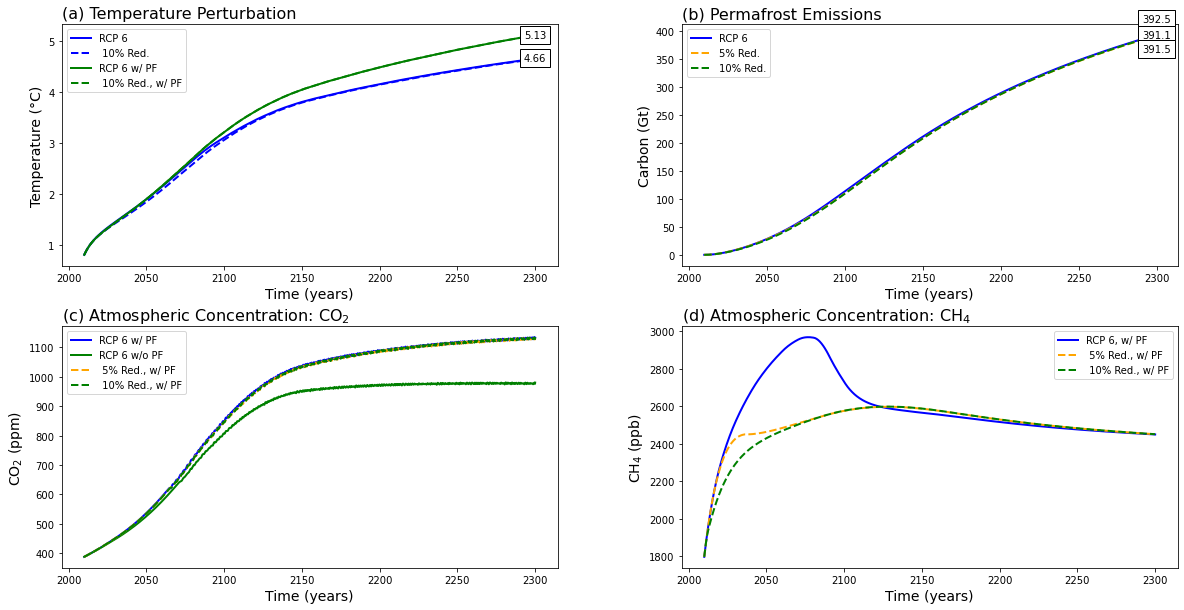

In [40]:
fig, ax1 = plt.subplots(2, 2, figsize=(20,10))
plt.subplots_adjust(wspace=0.25, hspace=0.25)

fs = 14


scen = "RCP 6"


t= np.arange(2010,2300,1)

coord = 0,0
ax1[coord].plot(sol6.t, sol6.y[0,:],linewidth=2, label = scen, color ="blue")
# ax1[coord].plot(sol1.t, sol45v1.y[0,:], linewidth=2, label = " 5% Red.", linestyle = "dashed")
ax1[coord].plot(sol6v10.t, sol6v10.y[0,:], linewidth=2, label = " 10% Red.", linestyle = "dashed", color ="blue")
ax1[coord].plot(sol6v10_PF.t, sol6v10_PF.y[0,:],linewidth=2, label = scen + " w/ PF", color ="green")
# ax1[coord].plot(sol1pf.t, sol45v1_PF.y[0,:],linewidth=2,  label = " 5% Red., w/ PF", linestyle = "dashed")
ax1[coord].plot(sol6v10_PF.t, sol6v10_PF.y[0,:], linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed", color = "green")

ax1[coord].text(2300, label6, label6, fontsize=10,
        bbox={'facecolor':'white', 'edgecolor':'black'},
        ha='center', va='center')
ax1[coord].text(2300, label6_PF, label6_PF , fontsize=10, 
      bbox={'facecolor':'white','edgecolor':'black'},
      ha='center', va='center')


ax1[coord].legend()
ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("Temperature (°C)", fontsize = fs)
ax1[coord].set_title("(a) Temperature Perturbation", loc='left', fontsize = fs +2)



coord= 0,1
ax1[coord].plot(t, netC6 * molCtoGT ,linewidth=2, label = scen, color = "blue")
ax1[coord].plot(t, netC6_v1 * molCtoGT ,linewidth=2, label = "5% Red.", linestyle = "dashed", color = "orange")
ax1[coord].plot(t, netC6_v10 * molCtoGT ,linewidth=2, label = "10% Red.", linestyle = "dashed", color ="green")
ax1[coord].text(2300, maxC6_v10 + 30, maxC6, fontsize=10,
                bbox={'facecolor':'white', 'edgecolor':'black'},
         ha='center', va='center')
ax1[coord].text(2300, maxC6, maxC6_v1, fontsize=10,
                bbox={'facecolor':'white','edgecolor':'black'},
         ha='center', va='center')
ax1[coord].text(2300, maxC6 - 25, maxC6_v10, fontsize=10,
                bbox={'facecolor':'white','edgecolor':'black'},
         ha='center', va='center')

ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("Carbon (Gt)", fontsize = fs)
ax1[coord].set_title("(b) Permafrost Emissions", loc='left', fontsize = fs +2)
ax1[coord].legend()


coord = 1,0
# ax1[coord].plot(sol.t, (sol.y[2,:] / ppmtoMol),linewidth=2, label = scen)
# ax1[coord].plot(sol1.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 1% Red.", linestyle = "dashed")
# ax1[coord].plot(sol2.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 10% Red.", linestyle = "dashed")
ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("CO$_2$ (ppm)", fontsize = fs)
ax1[coord].plot(sol6_PF.t, sol6_PF.y[2,:] / ppmtoMol, linewidth=2, label = scen + " w/ PF", color ="blue")
ax1[coord].plot(sol6.t, sol6.y[2,:] / ppmtoMol, linewidth=2, label = scen + " w/o PF", color ="green")

ax1[coord].plot(sol6v1_PF.t, sol6v1_PF.y[2,:] / ppmtoMol,linewidth=2,  label = " 5% Red., w/ PF", linestyle = "dashed", color ="orange")
ax1[coord].plot(sol6v10_PF.t, sol6v10_PF.y[2,:]/ ppmtoMol, linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed", color ="green")
ax1[coord].set_title("(c) Atmospheric Concentration: CO$_2$", loc='left', fontsize = fs +2)

ax1[coord].legend()



coord = 1,1
# ax1[coord].plot(sol.t,sol.y[8,:],linewidth=2, label = scen)
# ax1[coord].plot(sol1.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 1% Red.", linestyle = "dashed")
# ax1[coord].plot(sol2.t, (sol.y[2,:] / ppmtoMol), linewidth=2, label = " 10% Red.", linestyle = "dashed")
ax1[coord].set_xlabel("Time (years)", fontsize = fs)
ax1[coord].set_ylabel("CH$_4$ (ppb)", fontsize = fs)
ax1[coord].plot(sol6_PF.t, sol6_PF.y[8,:]*1e9/AM , linewidth=2, label = "RCP 6, w/ PF", color = "blue")
ax1[coord].plot(sol6v1_PF.t, sol6v1_PF.y[8,:] *1e9/AM,linewidth=2,  label = " 5% Red., w/ PF", linestyle = "dashed", color ="orange")
ax1[coord].plot(sol6v10_PF.t, sol6v10_PF.y[8,:]*1e9/AM, linewidth=2, label = " 10% Red., w/ PF", linestyle = "dashed", color ="green")
ax1[coord].set_title("(d) Atmospheric Concentration: CH$_4$", loc='left', fontsize = fs +2)

ax1[coord].legend()


# fname = "RCP6fixed.png"
# plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# files.download(fname)


In [41]:
# scen = "4.5"

# fig, ax1 = plt.subplots(2, 1, figsize=(15,12),dpi =300)
# fs = 14
# ax1[0].plot(sol.t, sol.y[0,:],linewidth=2, label = "RCP " + scen, linestyle = "dashed")
# ax1[0].plot(sol1.t, sol1.y[0,:], linewidth=2, label = "RCP "+ scen +" 1% Red.")
# ax1[0].plot(sol2.t, sol2.y[0,:], linewidth=2, label = "RCP "+ scen + " 10% Red.")
# ax1[0].set_xlabel("Time", fontsize = fs)
# ax1[0].set_ylabel("Temp Change C°", fontsize = fs)
# ax1[0].set_title("RCP "+ scen + " without Permafrost - Methane Scenarios", fontsize = fs +2)
# ax1[0].tick_params(axis='both', labelsize=fs-2)
# ax1[0].legend()


# ax1[1].plot(solpf.t, solpf.y[0,:],linewidth=2, label = "RCP "+  scen, linestyle = "dashed")
# ax1[1].plot(sol1pf.t, sol1pf.y[0,:],linewidth=2,  label = "RCP "+ scen +" 1% Red.")
# ax1[1].plot(sol2pf.t, sol2pf.y[0,:], linewidth=2, label = "RCP "+ scen + " 10% Red.")
# ax1[1].set_xlabel("Time", fontsize = fs)
# ax1[1].set_ylabel("Temp Change C°", fontsize = fs)
# ax1[1].set_title("RCP " + scen + " with Permafrost - Methane Scenarios", fontsize = fs+2)
# ax1[1].tick_params(axis='both', labelsize=fs -2)
# ax1[1].legend()

# fname = 'RCP' +scen + 'scenario.png'
# plt.savefig(fname, dpi=300, facecolor="white", bbox_inches='tight', pad_inches=0.05)
# # files.download(fname)